# P3 - OpenStreetMap Project - Tualatin, OR and Surrounding Areas


I live in a sleepy suburb of Portland, OR called Tualatin. Right from the start I had a sneaky feeling that I will come across "boring" (as in clean) data. I was Right! The dataset required very little normalization in the area of addresses and phone numbers. Boring or not, there are always questions we can ask of any data set, so I decided to investigate and see if I can find out why the data set is such a snoozer. What follows is the results of my investigation.


### Map Area
Tualatin, OR and the surrounding area.

OpenStreetMaps: https://www.openstreetmap.org/export#map=13/45.3787/-122.7393


### Additional External Resources Referenced:
N/A

### Step 1: Data Cleanup

##### Address Cleanup - 
Based on the Address cleanup script we created in the Case Study, I found only a handful of streets that required standardizations. I also added a conversion of "SW" to "Southwest" across all street names for consistency.

In [6]:
import xml.etree.cElementTree as ET
from collections import defaultdict
import re
import pprint

OSMFILE = "tualatin.osm"
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)


# These are the address suffix we're expecting
expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Lane", "Road", "Loop", "Woods",
            "Trail", "Parkway", "Circle", "Terrace", "Way", "Highway", "Path"]

# These are the suffixes we found in the file that need to be mapped to one of the above
mapping = { 
            "Ave": "Avenue",
            "Dr.": "Drive",
            "Rd": "Road"
          }

def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)


def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")


def audit(osmfile):
    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    osm_file.close()
    return street_types

def update_name(name, mapping):
    # YOUR CODE HERE
    name = name.split(' ')
    type = name[-1]
    if type in mapping:
        name[-1] = mapping[type]
        name = ' '.join(name)
        return name

def test():
    st_types = audit(OSMFILE)
    #pprint.pprint(dict(st_types))
    
    for st_type, ways in st_types.iteritems():
        for name in ways:
            better_name = update_name(name, mapping)
            if name == "SW Upper Boones Ferry Rd #100":
                better_name = "Southwest Upper Boones Ferry"
            elif name == "SW 74th":
                better_name = "Southwest 74th Avenue"
            elif name == "SW 91st":
                better_name = "Southwest 91st Avenue"
            elif name == "65th Avenue":
                better_name = "Southwest 65th Avenue"
            elif name == "6710 McEwan Road":
                better_name = "McEwan Road"
            print name, "=>", better_name

if __name__ == '__main__':
    test()

SW 91st => Southwest 91st Avenue
6710 McEwan Rd => 6710 McEwan Road
Upper Dr. => Upper Drive
SW Martinazzi Ave => SW Martinazzi Avenue
SW 65th Ave => SW 65th Avenue
SW Upper Boones Ferry Rd #100 => Southwest Upper Boones Ferry
SW 74th => Southwest 74th Avenue


##### Phone Number Cleanup - 
Applied the below function against the result set prior to saving the data to the CSV files to standardize phone numbers.

In [7]:
def clean_phone(phonenumber):
    phonePattern = re.compile(r'''(\d{3})\D*(\d{3})\D*(\d{4})\D*(\d*)$''')
    phonenumber = phonePattern.search(phonenumber).group()
    phonenumber = re.sub(" ", "-", phonenumber)
    phonenumber = re.sub("[()]", "", phonenumber)
    if re.match(r'\d{11}', phonenumber) is not None:
        phonenumber = phone_num[1:10]
    return phonenumber

### Step 2: Parsing the XML file from OpenStreetMaps and saving it to CSV files.
The following script was used to cleanup some of the data (phone numbers and addresses), parse the data from the OSM XML file, and save the results into 5 CSV files.

In [8]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import csv
import codecs
import re
import xml.etree.cElementTree as ET
from collections import defaultdict
from datetime import datetime

# Identify out XML file
OSM_PATH = "tualatin.osm"

# Create file paths for CSV files
NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"

# Define various Regular Expressions for value cleanup
LOWER_COLON = re.compile(r'^([a-z]|_)+:([a-z]|_)+')
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

# These are the address suffix we're expecting
expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Lane", "Road", "Loop", "Woods",
            "Trail", "Parkway", "Circle", "Terrace", "Way", "Highway", "Path"]

# These are the suffixes we found in the file that need to be mapped to one of the above
mapping = { 
            "Ave": "Avenue",
            "Dr.": "Drive",
            "Rd": "Road"
          }

# Here we define each CSV file's fields. This must match the column order in the sql table schema
NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']


def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

def clean_street(street):
    if street == "SW Upper Boones Ferry Rd #100":
        street = "Southwest Upper Boones Ferry"
    elif street == "SW 74th":
        street = "Southwest 74th Avenue"
    elif street == "SW 91st":
        street = "Southwest 91st Avenue"
    elif street == "65th Avenue":
        street = "Southwest 65th Avenue"
    elif street == "6710 McEwan Road":
        street = "McEwan Road"

    street = re.sub("SW", "Southwest", street)
    street = street.split(' ')
    type = street[-1]
    
    if (type in mapping):
        street[-1] = mapping[type]
    
    street = ' '.join(street)
    return street


# This function cleans up our phone numbers and removes country codes
def clean_phone(phonenumber):
    phonePattern = re.compile(r'''(\d{3})\D*(\d{3})\D*(\d{4})\D*(\d*)$''')
    phonenumber = phonePattern.search(phonenumber).group()
    phonenumber = re.sub(" ", "-", phonenumber)
    phonenumber = re.sub("[()]", "", phonenumber)
    if re.match(r'\d{11}', phonenumber) is not None:
        phonenumber = phone_num[1:10]
    return phonenumber


# Load a new tag dict to go into the list of dicts for way_tags, node_tags
def create_new_tag(element, secondlvl, default_tag_type):
    newtag = {}
    newtag['id'] = element.attrib['id']
    if ":" not in secondlvl.attrib['k']:
        newtag['key'] = secondlvl.attrib['k']
        newtag['type'] = default_tag_type
    else:
        post_colon = secondlvl.attrib['k'].index(":") + 1
        newtag['key'] = secondlvl.attrib['k'][post_colon:]
        newtag['type'] = secondlvl.attrib['k'][:post_colon - 1]

    # Cleaning up street names
    if is_street_name(secondlvl):
        street_name = clean_street(secondlvl.attrib['v'])
        newtag['value'] = street_name
    
    # Cleaning up phone numbers
    elif newtag['key'] == 'phone':
        phone_number = clean_phone(secondlvl.attrib['v'])
        if phone_number is not None:
            newtag['value'] = phone_number
        else:
            return None
    else:
        newtag['value'] = secondlvl.attrib['v']
    return newtag


#Clean and shape node or way XML element to Python dict
def shape_element(element, node_attr_fields=NODE_FIELDS, way_attr_fields=WAY_FIELDS,
                  problem_chars=PROBLEMCHARS, default_tag_type='regular'):

    node_attribs = {}
    way_attribs = {}
    way_nodes = []
    tags = []  # Handle nested tags the same way for both node and way elements

    if element.tag == 'node':
        for attrib, value in element.attrib.iteritems():
            if attrib in node_attr_fields:
                node_attribs[attrib] = value
        
        # For elements within the top element
        for secondlvl in element.iter():
            if secondlvl.tag == 'tag':
                if problem_chars.match(secondlvl.attrib['k']) is not None:
                    continue
                else:
                    newtag = create_new_tag(element, secondlvl, default_tag_type)
                    if newtag is not None:
                        tags.append(newtag)
        return {'node': node_attribs, 'node_tags': tags}
    
    elif element.tag == 'way':
        for attrib, value in element.attrib.iteritems():
            if attrib in way_attr_fields:
                way_attribs[attrib] = value

        counter = 0
        for secondlvl in element.iter():
            if secondlvl.tag == 'tag':
                if problem_chars.match(secondlvl.attrib['k']) is not None:
                    continue
                else:
                    newtag = create_new_tag(element, secondlvl, default_tag_type)
                    if newtag is not None:
                        tags.append(newtag)
            elif secondlvl.tag == 'nd':
                newnode = {}
                newnode['id'] = element.attrib['id']
                newnode['node_id'] = secondlvl.attrib['ref']
                newnode['position'] = counter
                counter += 1
                way_nodes.append(newnode)
        
        return {'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags}


# ================================================== #
#      Helper Functions - Provided by uDacity        #
# ================================================== #
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag"""

    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()

class UnicodeDictWriter(csv.DictWriter, object):
    """Extend csv.DictWriter to handle Unicode input"""

    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow({
            k: (v.encode('utf-8') if isinstance(v, unicode) else v) for k, v in row.iteritems()
        })

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)


# ================================================== #
#         Main Function - Provided by uDacity        #
# ================================================== #
def process_map(file_in):
    """Iteratively process each XML element and write to csv(s)"""

    with codecs.open(NODES_PATH, 'w') as nodes_file, \
         codecs.open(NODE_TAGS_PATH, 'w') as nodes_tags_file, \
         codecs.open(WAYS_PATH, 'w') as ways_file, \
         codecs.open(WAY_NODES_PATH, 'w') as way_nodes_file, \
         codecs.open(WAY_TAGS_PATH, 'w') as way_tags_file:

        nodes_writer = UnicodeDictWriter(nodes_file, NODE_FIELDS)
        node_tags_writer = UnicodeDictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
        ways_writer = UnicodeDictWriter(ways_file, WAY_FIELDS)
        way_nodes_writer = UnicodeDictWriter(way_nodes_file, WAY_NODES_FIELDS)
        way_tags_writer = UnicodeDictWriter(way_tags_file, WAY_TAGS_FIELDS)

        # Removed writeheader() lines to resolve data type conversion issue when loading data
        """
        nodes_writer.writeheader()
        node_tags_writer.writeheader()
        ways_writer.writeheader()
        way_nodes_writer.writeheader()
        way_tags_writer.writeheader()
        """

        for element in get_element(file_in, tags=('node', 'way')):
            el = shape_element(element)
            if el:
                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])
                    
                    
if __name__ == '__main__':
    start = datetime.now()
    print str(start) + ": Starting XML file parsing"
    process_map(OSM_PATH)
    end = datetime.now()
    delta = end - start
    print str(end) + ": CSV files created"
    print "It took the script " + str(delta.total_seconds()) + " seconds to run"


2016-10-09 07:42:26.653000: Starting XML file parsing
2016-10-09 07:42:39.280000: CSV files created
It took the script 12.627 seconds to run


### Step 3: Create a new SQLite DB and load the data:
The below schema was used to create 5 tables in a SQLite DB

##### SQLLite Schema

    CREATE TABLE nodes (
    id INTEGER PRIMARY KEY NOT NULL,
    lat REAL,
    lon REAL,
    user TEXT,
    uid INTEGER,
    version INTEGER,
    changeset INTEGER,
    timestamp TEXT);

    CREATE TABLE nodes_tags (
    id INTEGER,
    key TEXT,
    value TEXT,
    type TEXT,
    FOREIGN KEY (id) REFERENCES nodes(id));

    CREATE TABLE ways (
    id INTEGER PRIMARY KEY NOT NULL,
    user TEXT,
    uid INTEGER,
    version TEXT,
    changeset INTEGER,
    timestamp TEXT);

    CREATE TABLE ways_tags (
    id INTEGER NOT NULL,
    key TEXT NOT NULL,
    value TEXT NOT NULL,
    type TEXT,
    FOREIGN KEY (id) REFERENCES ways(id));

    CREATE TABLE ways_nodes (
    id INTEGER NOT NULL,
    node_id INTEGER NOT NULL,
    position INTEGER NOT NULL,
    FOREIGN KEY (id) REFERENCES ways(id),
    FOREIGN KEY (node_id) REFERENCES nodes(id));
    

##### Import CSV Tables in SQLite

    sqlite> .mode csv
    sqlite> .import nodes.csv nodes
    sqlite> .import nodes_tags.csv nodes_tags
    sqlite> .import ways.csv ways
    sqlite> .import ways_tags.csv ways_tags
    sqlite> .import ways_nodes.csv ways_nodes

### Step 4: Establishing Connectivity to our new SQLite database
To make it easy I created a function that will accept a SQL query string and will return a Dataframe with the requested results. I also loaded several python libraries to help with data visualization.

In [10]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3

# Function for establish connection and returning result set in a dataframe
def getmydata(query):
    conn = sqlite3.connect("P3.db")
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

Populating the interactive namespace from numpy and matplotlib


# Overview of the data

##### Q1: How many unique cities are in our dataset?
There are 8 unique city names in our dataset.

```SQL
SELECT DISTINCT value FROM ways_tags WHERE key IN ('city') AND value NOT LIKE ''
UNION
SELECT DISTINCT value FROM nodes_tags WHERE key IN ('city') AND value NOT LIKE ''
```

In [11]:
cities = "SELECT DISTINCT value FROM ways_tags WHERE key IN ('city') AND value NOT LIKE '' "
cities = cities + "UNION"
cities = cities + " SELECT DISTINCT value FROM nodes_tags WHERE key IN ('city') AND value NOT LIKE ''"

getmydata(cities)

,value
0,King City
1,Lake Oswego
2,Portland
3,Sherwood
4,Tigard
5,Tualatin
6,West Linn
7,Wilsonville


##### Q2: How many unique zip codes are in our dataset?
There are 8 unique zip codes in our dataset.

```SQL
SELECT DISTINCT value FROM ways_tags WHERE key IN ('postcode') AND value NOT LIKE ''
UNION
SELECT DISTINCT value FROM nodes_tags WHERE key IN ('postcode') AND value NOT LIKE ''
```

In [12]:
cities = "SELECT DISTINCT value FROM ways_tags WHERE key IN ('postcode') AND value NOT LIKE '' "
cities = cities + "UNION"
cities = cities + " SELECT DISTINCT value FROM nodes_tags WHERE key IN ('postcode') AND value NOT LIKE ''"

getmydata(cities)

,value
0,97034
1,97035
2,97062
3,97068
4,97070
5,97140
6,97223
7,97224


## The suburbs: Where they rip out the trees, and name streets after them...

One of my friends have a bumper sticker that reads "The suburbs: Where they rip out the trees, and name streets after them". Let’s look at the data and see if that's true.

##### Q3: Total number of unique streets in our dataset

```SQL
SELECT count(DISTINCT value) FROM ways_tags WHERE key IN ('street') AND value NOT LIKE '';
```

In [13]:
distinct_streets_df = getmydata("SELECT count(DISTINCT value) FROM ways_tags WHERE key IN ('street') AND value NOT LIKE '';")  
distinct_streets = distinct_streets_df.iloc[0][0]
print distinct_streets

1046


##### Q4: % of streets named after common trees in our dataset

In [14]:
#Common Tree Names
TREES = ['Abies','Acer','Aesculus','Alder','Alnus','Apple','Arborvitae','Arbutus','Ash','Aspen',
         'Basswood','Betula','Birch','Buckeye','Buckthorn','Calocedrus','Castanea','Castanopsis',
         'Catalpa','Cedar','Cedrus','Cercocarpus','Chamaecyparis','Cherry','Chestnut','Chinkapin',
         'Cornus','Corylus','Cottonwood','Crataegus','Cupressus','Cypress','Dogwood','Elaeagnus',
         'Elm','Filbert','Fir','Fraxinus','Giant','Gleditsia','Hawthorn','Hazel','Hemlock','Holly',
         'Honeylocust','Horsechestnut','Ilex','Incense','Juglans','Juniper','Juniperus','Larch',
         'Larix','Laurel','Laurel','Liquidambar','Liriodendron','Lithocarpus','Locust','Madrone',
         'mahogany','Maple','myrtle','Oak','Olive','Pear','Picea','Pine','Pinus','Platanus','Plum',
         'Poplar','Populus','Prunus','Pseudotsuga','Pyrus','Quercus','Redcedar','Redwood','Rhamnus',
         'Robinia','Salix','Sequoia','Sequoiadendron','Sorbus','Spruce','Sweetgum','Sycamore','Tanoak',
         'Taxus','Thuja','Tilia','Tsuga','Ulmus','Umbellularia','Walnut','Willow','Yew']

count = 0
for tree in TREES:
    unionq = "SELECT count(*) AS Count FROM "
    unionq = unionq + "(SELECT DISTINCT value FROM ways_tags WHERE key IN ('street') AND value NOT LIKE '' "
    unionq = unionq + "UNION"
    unionq = unionq + " SELECT DISTINCT value FROM nodes_tags WHERE key IN ('street') AND value NOT LIKE '') AS tbl "
    unionq = unionq + "WHERE value like '%" + tree + "%'"

    val = getmydata(unionq).iloc[0]['Count']
    if val > 0:
        count = count + 1
        # print tree + ' - ' + str(val)
tree_streets = count

##### Q5: % of streets named after common flowers in our dataset

In [15]:
#Common Flower Names
FLOWERS = ['Aconite','Ageratum','Allium','Alyssum','Anemone','Angelica','Angelonia','Archangel','Artemisia',
           'Aster','Astilbe','Aubrieta','Balsam','Baneberry','Begonia','Bellflower','Bergenia','Bleeding Heart',
           'Bloodroot','Bluebell','Boltonia','Boneset','Bowman','Browallia','Brunnera','Bugleweed',
           'Bugloss','Buttercup','Butterfly weed','Cabbage','Caladium','Calendula','Canary Creeper',
           'Candytuft','Cardinal','Catmint','Celosia','Chives','Cicely','Clary','Cleome','Cohosh',
           'Coleus','Columbine','Comfrey','Coneflower','Coreopsis','Corydalis','Cosmos','Crocus',
           'Cyclamen','Daffodil','Dahlia','Daisy','Daylily','Delphinium','Diascia','Echinacea','Epimedium',
           'Fennel','Flax','Foxglove','Gaillardia','Gaura','Gazania','Geranium','Geum','Ginger','Goatsbeard',
           'Gomphrena','Heliotrope','Hepatica','Hollyhock','Hosta','Hyacinth','Hyssop','Impatiens','Indigo',
           'Iris','Kale','Lantana','Lavender','Lavender','Leadwort','Lily','Lily','Lilyturf','Lobelia',
           'Loosestrife','Lupine','Marguerite','Marigold','Mazus','Mirabilis','Monkshood','Moonflower',
           'Morning Glory','Mugwort','Nasturtium','Nicotiana','Nierembergia','Osteospermum','Pansy','Pepper',
           'Petunia','Pincushion','Poppy','Portulaca','Prairie Mallow','Primrose','Rockcress','Rose','Rue',
           'Sage','Salvia','Sanvitalia','Senna','Shooting Star','Silvermound','Snakeroot','Snapdragon',
           'Snowdrop','Soapwort','Spurge','Statice','Tansy','Thistle','Thunbergia','Tithonia','Torenia',
           'Trillium','Tulip','Valerian','Verbena','Vinca','Viola','Violet','Windflower','Woodruff',
           'Wormwood','Yarrow','Zinnia']

count = 0
for flower in FLOWERS:
    unionq = "SELECT count(*) AS Count FROM "
    unionq = unionq + "(SELECT DISTINCT value FROM ways_tags WHERE key IN ('street') AND value NOT LIKE '' "
    unionq = unionq + "UNION"
    unionq = unionq + " SELECT DISTINCT value FROM nodes_tags WHERE key IN ('street') AND value NOT LIKE '') AS tbl "
    unionq = unionq + "WHERE value like '%" + flower + "%'"

    val = getmydata(unionq).iloc[0]['Count']
    if val > 0:
        count = count + 1
        #print flower + ' - ' + str(val)
flower_streets = count

## So... is it true?
It seems that this is not the case in my suburb. Only 2.49% of the streets contain a name of a tree from our common trees list. Similarly, only 0.76%

In [16]:
print 'Total streets names in our dataset: ' + str(distinct_streets)
print 'Total streets that contain a name of a tree: ' + str(tree_streets) + ' ' \
                    + "{:.2%}".format((float(tree_streets)/(float(distinct_streets))))
print 'Total streets that contain a name of a flower: ' + str(flower_streets)  + ' ' \
                    + "{:.2%}".format((float(flower_streets)/(float(distinct_streets))))

Total streets names in our dataset: 1046
Total streets that contain a name of a tree: 26 2.49%
Total streets that contain a name of a flower: 8 0.76%


##### Q6: Number of distinct users

```SQL
SELECT COUNT(*) AS TotalUsers FROM 
        (SELECT DISTINCT user FROM ways 
        UNION
        SELECT DISTINCT user FROM nodes);
```

In [17]:
getmydata('SELECT COUNT(*) AS TotalUsers FROM (SELECT DISTINCT user FROM ways UNION SELECT DISTINCT user FROM nodes);')

,TotalUsers
0,120


##### Q7/Q8: who contributed and how much? Is there a difference in contributions between ways and nodes?
In order to find this out I created 3 dataframes:
- ways_users - Distinct list of users and the counts of contributions they made to the ways dataset
- nodes_users - Distinct list of users and the counts of contributions they made to the nodes dataset
- compare_users - a comparison of the top 10 contributors

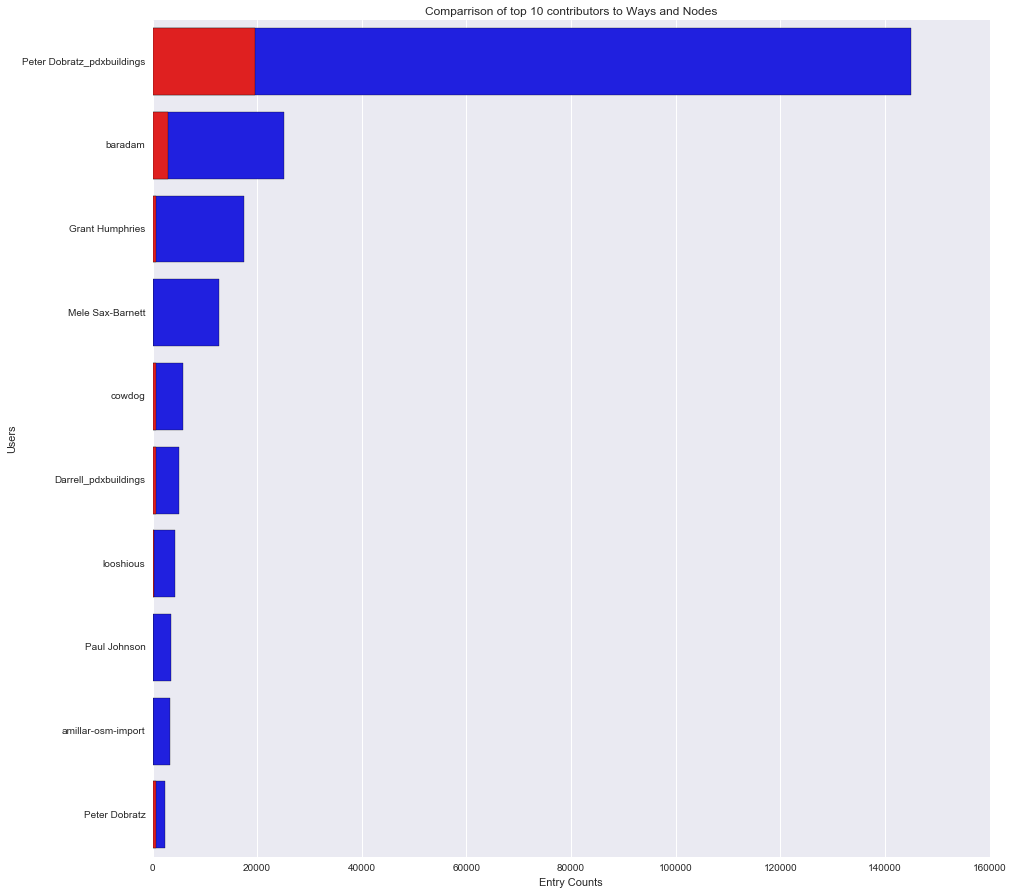

In [18]:
ways_users = getmydata('select user, count(id) As ways from ways group by user order by count(id);')
nodes_users = getmydata('select user, count(id) As nodes from nodes group by user order by count(id);')
compare_users = ways_users.merge(nodes_users, on=['user'], how='outer').sort_values(['nodes'], ascending=[0]).head(10)

# format plot
fig, (axis1) = plt.subplots(1,figsize=(15,15))

compare_users_plot = sns.barplot(y='user', x='nodes', data=compare_users, ax=axis1, color = 'b')
compare_users_plot = sns.barplot(y='user', x='ways', data=compare_users, ax=axis1, color = 'r')

sns.set(style="whitegrid", color_codes=False)
    
# add titles
compare_users_plot.axes.set_title('Comparrison of top 10 contributors to Ways and Nodes')
compare_users_plot.set_ylabel("Users")
compare_users_plot.set_xlabel("Entry Counts")

##### Q9: What are the top 10 amenities listed in the dataset?

```SQL
SELECT value, count(*) FROM nodes_tags WHERE key LIKE 'amenity' 
GROUP BY value 
ORDER BY count(*) DESC LIMIT 10;
```

In [19]:
getmydata("SELECT value, count(*) FROM nodes_tags WHERE key like 'amenity' group by value order by count(*) desc LIMIT 10;")

,value,count(*)
0,parking,35
1,place_of_worship,35
2,restaurant,14
3,fast_food,10
4,post_box,10
5,bank,9
6,school,9
7,bicycle_parking,7
8,shelter,7
9,cafe,6


##### Q10: What are the place of worship religions in our dataset?
Seems that the reigning religion in our area is Christianity.
```SQL
SELECT value, COUNT(*) FROM nodes_tags,
(SELECT DISTINCT id FROM nodes_tags WHERE value='place_of_worship') As node_ids
WHERE nodes_tags.id = node_ids.id AND nodes_tags.key='religion'
GROUP BY nodes_tags.value ORDER BY count(*) DESC;
```

In [20]:
query = "SELECT value, COUNT(*) FROM nodes_tags," + \
            " (SELECT DISTINCT id FROM nodes_tags WHERE value='place_of_worship') As node_ids" + \
            " WHERE nodes_tags.id = node_ids.id AND nodes_tags.key='religion'" + \
            " GROUP BY nodes_tags.value ORDER BY count(*) DESC;"

getmydata(query)

,value,COUNT(*)
0,christian,34
1,buddhist,1


# Other ideas about the datasets

As you can see from our data, there's not a whole lot going on in Tualatin, OR. Having said that, there are multiple other aspects that can be explored in the dataset:
- What is the average number of houses per street?
- What is the time span of the additions and modifications of the data?
- What is the ratio of schools to houses in the area?
- How many houses are positioned on a corner?


### Improving Data Quality - Suggestion 1:

##### Origins of the OpenStreetMaps Data - 
Looking at our top 10 contributors, I came across three users that peaked my interested: "peter dobratz_pdxbuildings", "peter dobratz" and "Darrel_pdxbuildings". These two users (assuming "peter dobratz_pdxbuildings" and "peter dobratz" are the same user with different ids) are the owners of 72.50% of the ways (20,870 out of 28,784) and 64.78% of nodes (152,463 out of 235,350) data points. With such a high percentage of information coming from these users, I believe it would be worth while to investigate the origin and quality of their data.

In [60]:
print ways_users \
    .query('user == "Peter Dobratz_pdxbuildings" or user == "Peter Dobratz" or user == "Darrell_pdxbuildings"')
print ''
print getmydata('select count(*) As ways from ways;')

                          user   ways
66        Darrell_pdxbuildings    639
67               Peter Dobratz    671
72  Peter Dobratz_pdxbuildings  19560

    ways
0  28784


In [61]:
print nodes_users \
    .query('user == "Peter Dobratz_pdxbuildings" or user == "Peter Dobratz" or user == "Darrell_pdxbuildings"')
print ''
print getmydata('select count(*) As nodes from nodes;')

                           user   nodes
91                Peter Dobratz    2306
95         Darrell_pdxbuildings    5133
100  Peter Dobratz_pdxbuildings  145024

    nodes
0  230350


##### Possible Implementation Obstacles -
Depending on the policies of OpenStreetMaps, we may not be able to find out who these users are and how they came about to contribute such a high percentage of the data points.


### Improving Data Quality - Suggestion 2:

##### Increasing Data Granularity -
Something I noticed while cleaning up the addresses is that the street includes not just the street name and designation (i.e. "Street", "Road", "Circle", etc...) but also the quadrants. In this dataset's case, the only quadrant possible is Southwest so it is fairly easy to identify and validate, but capturing the data in a more granular way so these three components are separated will make data cleanup and validation much easier. One example would be to be able to compare the street quadrant with its coordinate points and ensure that the quadrants indicated are correct based on the streets location within its area (for example, identifying a street marked as "Southwest" that is actually in the Northwest quadrant based on its coordinates).

##### Possible Implementation Obstacles -
Validating that the area in question truly follows the grid system may be an issue and will most likely vary from area to area. Evaluating the street position across its entire length may also present a problem if the street happens to cross quadrants in its paths yet the quadrants of the street itself remain the same for all addresses within it.


### Improving Data Quality - Suggestion 3:

##### Suggestion for Data Validation Against External Sources -
Although most streets have a speed limit data point indicated, I wasn't able to find any indication of school zones, which vary the speed limit by the hour, day and time of the year. It may be possible to use a data source like Waze, that captures the actual speed of its users and estimate the time periods where the school zone speed limit is in effect.

##### Possible Implementation Obstacles -
We may come across data bias hidden in the Waze data that will skew our analysis. For example, do Waze users tend to drive faster than others drivers? are drivers that frequent school zones more or less likely to use Waze? Also, how do we determine that the speed cars are driving is truly due to a school zone speed limit as opposed to just an urban traffic jam near a school?